In [19]:
try:
    from tonic.datasets.nmnist import NMNIST
except ImportError:
    ! pip install tonic
    from tonic.datasets.nmnist import NMNIST
    
# download dataset
root_dir = "./NMNIST"
_ = NMNIST(save_to=root_dir, train=True)
# _ = NMNIST(save_to=root_dir, train=False)

In [2]:
from torch import nn


# define a CNN model
cnn = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3, 3), padding=(1, 1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    # [8, 17, 17] -> [16, 8, 8]
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    # [16 * 8 * 8] -> [16, 4, 4]
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), stride=(2, 2),  bias=False),
    nn.ReLU(),
    # [16 * 4 * 4] -> [10]
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 10, bias=False),
    nn.ReLU(),
)

# init the model weights
for layer in cnn.modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(layer.weight.data)


In [3]:
from tonic.transforms import ToFrame
from tonic.datasets import nmnist

# define a transform that accumulate the events into a single frame image
to_frame = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=1)

cnn_train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_frame)
cnn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_frame)

# check the transformed data
sample_data, label = cnn_train_dataset[0]
print(f"The transformed array is in shape [Time-Step, Channel, Height, Width] --> {sample_data.shape}")

The transformed array is in shape [Time-Step, Channel, Height, Width] --> (1, 2, 34, 34)


In [15]:
!pip install ipywidgets

In [19]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm.notebook import tqdm
from torch.nn import CrossEntropyLoss

epochs = 0
lr = 1e-3
batch_size = 4
num_workers = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
shuffle = True

cnn = cnn.to(device=device)

cnn_train_dataloader = DataLoader(cnn_train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)
cnn_test_dataloader = DataLoader(cnn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)

optimizer = SGD(params=cnn.parameters(), lr=lr)
criterion = CrossEntropyLoss()

for e in range(epochs):

    # train
    train_p_bar = tqdm(cnn_train_dataloader)
    for data, label in train_p_bar:
        # remove the time-step axis since we are training CNN
        # move the data to accelerator
        data = data.squeeze(dim=1).to(dtype=torch.float, device=device)
        label = label.to(dtype=torch.long, device=device)
        # forward
        optimizer.zero_grad()
        output = cnn(data)
        loss = criterion(output, label)
        # backward
        loss.backward()
        optimizer.step()
        # set progressing bar
        train_p_bar.set_description(f"Epoch {e} - Training Loss: {round(loss.item(), 4)}")

    # validate
    correct_predictions = []
    with torch.no_grad():
        test_p_bar = tqdm(cnn_test_dataloader)
        for data, label in test_p_bar:
            # remove the time-step axis since we are training CNN
            # move the data to accelerator
            data = data.squeeze(dim=1).to(dtype=torch.float, device=device)
            label = label.to(dtype=torch.long, device=device)
            # forward
            output = cnn(data)
            # calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            # compute the total correct predictions
            correct_predictions.append(pred.eq(label.view_as(pred)))
            # set progressing bar
            test_p_bar.set_description(f"Epoch {e} - Testing Model...")
    
        correct_predictions = torch.cat(correct_predictions)
        print(f"Epoch {e} - accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%")

In [25]:
# 保存模型到本地文件
torch.save(cnn.state_dict(), "cnn_trained_model.pth")
torch.save(cnn, "cnn_entire_model.pth")


In [20]:
cnn = torch.load("cnn_entire_model.pth",map_location="cpu")

In [21]:
from sinabs.from_torch import from_model

snn_convert = from_model(model=cnn, input_shape=(2, 34, 34), batch_size=batch_size).spiking_model
snn_convert

Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=4, num_timesteps=-1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=4, num_timesteps=-1)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=4, num_timesteps=-1)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=10, bias=False)
  (10): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Pa

In [22]:
# define a transform that accumulate the events into a raster-like tensor
n_time_steps = 100
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

snn_convert = snn_convert.to(device)

correct_predictions = []
with torch.no_grad():
    test_p_bar = tqdm(snn_test_dataloader)
    for data, label in test_p_bar:
        # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
        data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
        label = label.to(dtype=torch.long, device=device)
        # forward
        output = snn_convert(data)
        # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
        output = output.reshape(batch_size, n_time_steps, -1)
        # accumulate all time-steps output for final prediction
        output = output.sum(dim=1)
        # calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        # compute the total correct predictions
        correct_predictions.append(pred.eq(label.view_as(pred)))
        # set progressing bar
        test_p_bar.set_description(f"Testing SNN Model...")

    correct_predictions = torch.cat(correct_predictions)
    print(f"accuracy of converted SNN: {correct_predictions.sum().item()/(len(correct_predictions))*100}%")

  0%|          | 0/2500 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/__init__.py", line 1854, in <module>
    from . import _meta_registrations
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/_meta_registrations.py", line 9, in <module>
    from torch._decomp import (
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/_decomp/__init__.py", line 244, in <module>
    import torch._refs
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/_refs/__init__.py", line 308

KeyboardInterrupt: 

### SNN

In [29]:
import sinabs.layers as sl
from torch import nn
from sinabs.activation.surrogate_gradient_fn import PeriodicExponential
batch_size = 4

# just replace the ReLU layer with the sl.IAFSqueeze
snn_bptt = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3, 3), padding=(1, 1), bias=False),
    sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential()),
    nn.AvgPool2d(2, 2),
    # [8, 17, 17] -> [16, 8, 8]
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
    sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential()),
    nn.AvgPool2d(2, 2),
    # [16 * 8 * 8] -> [16, 4, 4]
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), stride=(2, 2),  bias=False),
    sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential()),
    # [16 * 4 * 4] -> [10]
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 10, bias=False),
    sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential()),
)

# init the model weights
for layer in snn_bptt.modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(layer.weight.data)

In [20]:
###

In [30]:
n_time_steps = 100
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)

snn_train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_raster)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)


NameError: name 'ToFrame' is not defined

In [31]:
epochs = 0
lr = 1e-3
batch_size = 4
num_workers = 4
# device = "cuda:0"
shuffle = True

snn_train_dataloader = DataLoader(snn_train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

snn_bptt = snn_bptt.to(device=device)

optimizer = SGD(params=snn_bptt.parameters(), lr=lr)
criterion = CrossEntropyLoss()

for e in range(epochs):

    # train
    train_p_bar = tqdm(snn_train_dataloader)
    for data, label in train_p_bar:
        # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
        data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
        label = label.to(dtype=torch.long, device=device)
        # forward
        optimizer.zero_grad()
        output = snn_bptt(data)
        # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
        output = output.reshape(batch_size, n_time_steps, -1)
        # accumulate all time-steps output for final prediction
        output = output.sum(dim=1)
        loss = criterion(output, label)
        # backward
        loss.backward()
        optimizer.step()
        
        # detach the neuron states and activations from current computation graph(necessary)
        for layer in snn_bptt.modules():
            if isinstance(layer, sl.StatefulLayer):
                for name, buffer in layer.named_buffers():
                    buffer.detach_()
        
        # set progressing bar
        train_p_bar.set_description(f"Epoch {e} - BPTT Training Loss: {round(loss.item(), 4)}")

    # validate
    correct_predictions = []
    with torch.no_grad():
        test_p_bar = tqdm(snn_test_dataloader)
        for data, label in test_p_bar:
            # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
            data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
            label = label.to(dtype=torch.long, device=device)
            # forward
            output = snn_bptt(data)
            # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
            output = output.reshape(batch_size, n_time_steps, -1)
            # accumulate all time-steps output for final prediction
            output = output.sum(dim=1)
            # calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            # compute the total correct predictions
            correct_predictions.append(pred.eq(label.view_as(pred)))
            # set progressing bar
            test_p_bar.set_description(f"Epoch {e} - BPTT Testing Model...")
    
        correct_predictions = torch.cat(correct_predictions)
        print(f"Epoch {e} - BPTT accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%")

NameError: name 'DataLoader' is not defined

In [26]:
torch.save(snn_bptt.state_dict(), "snn_bptt_model.pth")
torch.save(snn_bptt, "snn_bptt_fullmodel.pth")



In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

snn_bptt = torch.load("snn_bptt_fullmodel.pth",map_location="cpu")
snn_bptt.eval().to(device)


Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=4, num_timesteps=-1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=4, num_timesteps=-1)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=4, num_timesteps=-1)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=10, bias=False)
  (10): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Pa

In [38]:
from sinabs.backend.dynapcnn import DynapcnnNetwork

# cpu_snn = snn_convert.to(device="cpu")
cpu_snn = snn_bptt.to(device="cpu")
dynapcnn = DynapcnnNetwork(snn=cpu_snn, input_shape=(2, 34, 34), discretize=True, dvs_input=False)
devkit_name = "speck2fdevkit"

# use the `to` method of DynapcnnNetwork to deploy the SNN to the devkit
dynapcnn.to(device=devkit_name, chip_layers_ordering="auto")
print(f"The SNN is deployed on the core: {dynapcnn.chip_layers_ordering}")

Network is valid
The SNN is deployed on the core: [0, 1, 2, 3]


In [30]:
import samna
from collections import Counter
from torch.utils.data import Subset

snn_test_dataset = NMNIST(save_to=root_dir, train=False)
# for time-saving, we only select a subset for on-chip infernce， here we select 1/100 for an example run
subset_indices = list(range(0, len(snn_test_dataset), 100))
snn_test_dataset = Subset(snn_test_dataset, subset_indices)

inferece_p_bar = tqdm(snn_test_dataset)

test_samples = 0
correct_samples = 0

for events, label in inferece_p_bar:

    # create samna Spike events stream
    samna_event_stream = []
    for ev in events:
        spk = samna.speck2f.event.Spike()
        spk.x = ev['x']
        spk.y = ev['y']
        spk.timestamp = ev['t'] - events['t'][0]
        spk.feature = ev['p']
        # Spikes will be sent to layer/core #0, since the SNN is deployed on core: [0, 1, 2, 3]
        spk.layer = 0
        samna_event_stream.append(spk)

    # inference on chip
    # output_events is also a list of Spike, but each Spike.layer is 3, since layer#3 is the output layer
    output_events = dynapcnn(samna_event_stream)
    
    # use the most frequent output neruon index as the final prediction
    neuron_index = [each.feature for each in output_events]
    if len(neuron_index) != 0:
        frequent_counter = Counter(neuron_index)
        prediction = frequent_counter.most_common(1)[0][0]
    else:
        prediction = -1
    inferece_p_bar.set_description(f"label: {label}, prediction: {prediction}， output spikes num: {len(output_events)}") 

    if prediction == label:
        correct_samples += 1

    test_samples += 1
    
print(f"On chip inference accuracy: {correct_samples / test_samples}")        

  0%|          | 0/100 [00:00<?, ?it/s]

`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enabl

On chip inference accuracy: 0.92


In [39]:
from sinabs.backend.dynapcnn.dynapcnn_visualizer import DynapcnnVisualizer

import samna
# first define a callback function to modify the devkit configuration
# the callback function should only has 1 devkit config instance as its input argument
def config_modify_callback(devkit_cfg):

    # enable visualizing the output from dvs(pre-processing) layer
    devkit_cfg.dvs_layer.monitor_enable = True
    # disable visualizing the events generated by the embedded dvs on Speck
    devkit_cfg.dvs_layer.raw_monitor_enable = False
    # prevent the events generated by the embedded dvs been feed to the DynapCNN Core.
    devkit_cfg.dvs_layer.pass_sensor_events = False
    # point the dvs layer output destination to the core#0 
    devkit_cfg.dvs_layer.destinations[0].enable = True
    devkit_cfg.dvs_layer.destinations[0].layer = 0

    # the callback must return the modified devkit config
    return devkit_cfg

# close the devkit before reopen
# samna.device.close_device(dynapcnn.samna_device)

# init DynapcnnNetwork instance
dynapcnn = DynapcnnNetwork(snn=cpu_snn, input_shape=(2, 34, 34), discretize=True, dvs_input=True)

# define which layers output you want to monitor
layers_to_monitor = [0, 1, 2, 3]
# pass the callback function into the `.to` method
dynapcnn.to(device=devkit_name, chip_layers_ordering=[0, 1, 2, 3], monitor_layers=layers_to_monitor, config_modifier=config_modify_callback)
print(f"The SNN is deployed on the core: {dynapcnn.chip_layers_ordering}")

visualizer = DynapcnnVisualizer(
    window_scale=(4, 8),
    dvs_shape=(34, 34),
    spike_collection_interval=50,
)

visualizer.connect(dynapcnn)

/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:305: UserWarning: Layer 0 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:305: UserWarning: Layer 1 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(


Network is valid
The SNN is deployed on the core: [0, 1, 2, 3]
Connecting: Please wait until the JIT compilation is done, this might take a while. You will get notified on completion.


TypeError: cannot pickle 'PyCapsule' object

In [31]:
from collections import Counter
from torch.utils.data import Subset
import samna

snn_test_dataset = NMNIST(save_to=root_dir, train=False)
# for time-saving, we only select a subset for on-chip infernce， here we select 1/100 for an example run
subset_indices = list(range(0, len(snn_test_dataset), 100))
snn_test_dataset = Subset(snn_test_dataset, subset_indices)

inferece_p_bar = tqdm(snn_test_dataset)

for events, label in inferece_p_bar:

    # instead of creating Spike and send it to core#0 directly, we now create DvsEvent(for visualization) and send it to the DVS layer
    # since in the "config_modify_callback" we point the output destination layer of the DVS layer to layer/core #0
    # so the DynacnnCore can still receive the same input as before.
    samna_event_stream = []
    for ev in events:
        dvs_ev = samna.speck2f.event.DvsEvent()
        dvs_ev.x = ev['x']
        dvs_ev.y = ev['y']
        dvs_ev.timestamp = ev['t'] - events['t'][0]
        dvs_ev.p = ev['p']
        samna_event_stream.append(dvs_ev)

    # inference on chip
    # output_events is also a list of Spike, but .layer will have 0, 1, 2, 3 since we choose to monitor all layers' output
    output_events = dynapcnn(samna_event_stream)
    
    # get each layers output spikes
    layer0_spks = [each.feature for each in output_events if each.layer == 0]
    layer1_spks = [each.feature for each in output_events if each.layer == 1]
    layer2_spks = [each.feature for each in output_events if each.layer == 2]
    layer3_spks = [each.feature for each in output_events if each.layer == 3]
    # use the most frequent output neruon index as the final prediction
    if len(layer3_spks) != 0:
        frequent_counter = Counter(layer3_spks)
        prediction = frequent_counter.most_common(1)[0][0]
    else:
        prediction = -1
    inferece_p_bar.set_description(f"label: {label} prediction: {prediction}，layer 0 output spks: {len(layer0_spks)},layer 1 output spikes num: {len(layer1_spks)}, layer 2 output spikes num: {len(layer2_spks)},layer 3 output spikes num: {len(layer3_spks)}") 

    if prediction == label:
        correct_samples += 1

    test_samples += 1
    
print(f"On chip inference accuracy: {correct_samples / test_samples}")  

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1164ce170>
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


  0%|          | 0/100 [00:00<?, ?it/s]

`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.


KeyboardInterrupt: 

In [41]:
import samna
import samnagui
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

from torch import nn
from multiprocessing import Process
from sinabs.from_torch import from_model
from sinabs.backend.dynapcnn import DynapcnnNetwork

# get device name
devices = samna.device.get_all_devices()
device_names = [each.device_type_name for each in devices]
device_names

# open devkit
devkit = samna.device.open_device(device_names[0])

# get the handle of the stop-watch of the devkit
stop_watch = devkit.get_stop_watch()

# get the handle of the power monitor of the devkit
power_monitor = devkit.get_power_monitor()

# create samna node for power reading
power_source_node = power_monitor.get_source_node()
power_buffer_node = samna.BasicSinkNode_unifirm_modules_events_measurement()

RuntimeError: No devices available!

In [40]:
# init graph
samna_graph = samna.graph.EventFilterGraph()

import time

# build graph
samna_graph.sequential([power_source_node, power_buffer_node])
time.sleep(0.5)


Graph is destroyed while running! Note: Filter nodes constructed by `sequential` method won't work after corresponding graph is destroyed and please manually stop the graph after use.


In [42]:
measure_time = 5.0  # seconds
sample_rate = 100.0  # Hz

# start samna graph
samna_graph.start()

# start the stop-watch of devkit, then each output data has a proper timestamp
stop_watch.set_enable_value(True)

# clear buffer
power_buffer_node.get_events()

# start monitor, we need pass a sample rate argument to the power monitor
power_monitor.start_auto_power_measurement(sample_rate)

# sleep the procees to wait for the measurement time up
time.sleep(measure_time)

# stop monitor
power_monitor.stop_auto_power_measurement()

# stop samna graph
samna_graph.stop()

# get power-measurement data
power_events = power_buffer_node.get_events()

`set_enable_value` is DEPRECATED, use `start` and `stop` instead.


RuntimeError: Auto measurement is already active.

In [14]:
# time * sample rate * number of power tracks
estimated_number_of_data = measure_time * sample_rate * 5
print(f"estimated number of collect data: {estimated_number_of_data}")

print(f"number of collected data: {len(power_events)}")

estimated number of collect data: 2500.0
number of collected data: 2497


In [44]:
num_power_tracks = 5

# init dict for storing data of each power track
power_each_track = dict()
event_count_each_track = dict()

# check whether timestamp is correct
timestamp_all_zero = True

# loop through all collected power events and get data
for evt in power_events:

    if evt.timestamp != 0:
        timestamp_all_zero = False
    
    p_track_id = evt.channel
    tmp_power = power_each_track.get(p_track_id, 0) + evt.value
    tmp_count = event_count_each_track.get(p_track_id, 0) + 1
    
    power_each_track.update({p_track_id: tmp_power})
    event_count_each_track.update({p_track_id: tmp_count})

# average power and current of each track
for p_track_id in range(num_power_tracks):
    
    # average power in microwatt
    avg_power = power_each_track[p_track_id] / event_count_each_track[p_track_id] * 1e6
    # calculate current
    if p_track_id == 0:
        current = avg_power / 2.5 
    else:
        current = avg_power / 1.2
        
    print(f'track{p_track_id}: {avg_power}uW, {current}uA')

track0: 40.19709777832036uW, 16.078839111328143uA
track1: 68.84974888392819uW, 57.374790736606826uA
track2: 279.88349746367686uW, 233.2362478863974uA
track3: 41.24040491697666uW, 34.36700409748055uA
track4: 764.2737344107838uW, 636.8947786756532uA


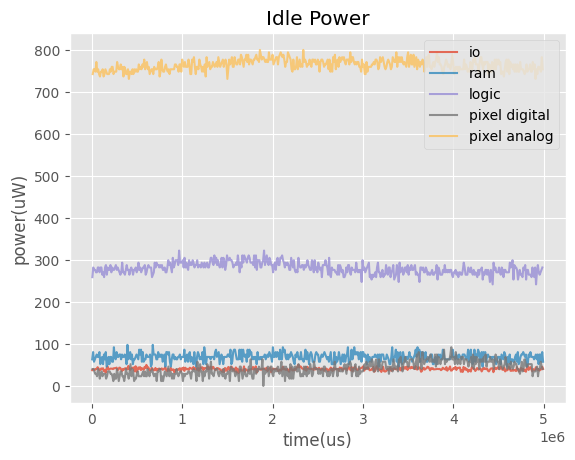

In [16]:
from matplotlib import pyplot as plt

if timestamp_all_zero:
    
    print("timestamps are all zeros, can't plot power vs. time, you might need to update the firmware!")
    
else:
    
    # plot the output neuron index vs. time
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    p_track_name = ["io", "ram", "logic", "pixel digital", "pixel analog"]
    for p_track_id in range(num_power_tracks):
        x = [each.timestamp for each in power_events if each.channel == p_track_id]
        y = [each.value * 1e6 for each in power_events if each.channel == p_track_id]
        plt.plot(x, y, label=p_track_name[p_track_id], alpha=0.8)
        
    ax.set_xlabel("time(us)")
    ax.set_ylabel("power(uW)")
    ax.set_title("Idle Power")
    ax.legend(loc="upper right", fontsize=10)

In [45]:
import time
from collections import Counter
from torch.utils.data import Subset
from tqdm import tqdm


def measure_average_power(sample_rate=100.0, duration=5.0):
    power_monitor.start_auto_power_measurement(sample_rate)
    stop_watch.set_enable_value(True)
    power_buffer_node.get_events()
    time.sleep(duration)
    power_monitor.stop_auto_power_measurement()
    power_events = power_buffer_node.get_events()

    num_tracks = 5
    power_sum = [0.0] * num_tracks
    power_count = [0] * num_tracks
    for evt in power_events:
        power_sum[evt.channel] += evt.value
        power_count[evt.channel] += 1
    avg_uw = [power_sum[i] / power_count[i] * 1e6 for i in range(num_tracks)]
    total_mw = sum(avg_uw) / 1000.0
    return avg_uw, total_mw

# # ====== Step 1: Idle Power ======
# print("Measuring idle power...")
# idle_avg_uw, idle_total_mw = measure_average_power(duration=5.0)
# print(f"Idle power: {idle_total_mw:.2f} mW ({idle_avg_uw})")

# ====== Step 2: Active Power + Inference ======
print("Running inference and measuring active power...")


try: 
    # stop monitor
    power_monitor.stop_auto_power_measurement()

    # stop samna graph
    samna_graph.stop()
except:
    pass

sample_rate = 1

# start samna graph
samna_graph.start()

# start the stop-watch of devkit, then each output data has a proper timestamp
stop_watch.set_enable_value(True)

# clear buffer
power_buffer_node.get_events()

# start monitor, we need pass a sample rate argument to the power monitor
power_monitor.start_auto_power_measurement(sample_rate)

start_time = time.time()

# N-MNIST 推理
snn_test_dataset = NMNIST(save_to=root_dir, train=False)
subset_indices = list(range(0, len(snn_test_dataset), 1000))
snn_test_dataset = Subset(snn_test_dataset, subset_indices)

correct_samples = 0
test_samples = 0
for events, label in tqdm(snn_test_dataset):
    spike_events = []
    for ev in events:
        spk = samna.speck2f.event.Spike()
        spk.x, spk.y, spk.timestamp, spk.feature = ev["x"], ev["y"], ev["t"] - events["t"][0], ev["p"]
        spk.layer = 0
        spike_events.append(spk)

    output_events = dynapcnn(spike_events)
    layer3_spks = [e.feature for e in output_events if e.layer == 3]
    prediction = Counter(layer3_spks).most_common(1)[0][0] if layer3_spks else -1
    if prediction == label:
        correct_samples += 1
    test_samples += 1

end_time = time.time()

# stop monitor
power_monitor.stop_auto_power_measurement()

# stop samna graph
samna_graph.stop()

# get power-measurement data
active_power_events = power_buffer_node.get_events()

# time * sample rate * number of power tracks
estimated_number_of_data = measure_time * sample_rate * 5
print(f"estimated number of collect data: {estimated_number_of_data}")

print(f"number of collected data: {len(power_events)}")

# ====== Step 3: Compute active power ======
# active_avg_uw = [0.0] * 5
# active_count = [0] * 5
# for evt in active_power_events:
#     active_avg_uw[evt.channel] += evt.value
#     active_count[evt.channel] += 1
# active_avg_uw = [active_avg_uw[i] / active_count[i] * 1e6 for i in range(5)]
# active_total_mw = sum(active_avg_uw) / 1000.0

num_power_tracks = 5

# init dict for storing data of each power track
power_each_track = dict()
event_count_each_track = dict()

# check whether timestamp is correct
timestamp_all_zero = True

# loop through all collected power events and get data
for evt in active_power_events:

    if evt.timestamp != 0:
        timestamp_all_zero = False
    
    p_track_id = evt.channel
    tmp_power = power_each_track.get(p_track_id, 0) + evt.value
    tmp_count = event_count_each_track.get(p_track_id, 0) + 1
    
    power_each_track.update({p_track_id: tmp_power})
    event_count_each_track.update({p_track_id: tmp_count})

    print(f"track {p_track_id} power: {power_each_track[p_track_id]}")
    print(f"track {p_track_id} event count: {event_count_each_track[p_track_id]}")

# average power and current of each track
for p_track_id in range(num_power_tracks):

    # print(f"track {p_track_id} power: {power_each_track[p_track_id]}")
    # print(f"track {p_track_id} event count: {event_count_each_track[p_track_id]}")
    
    # average power in microwatt
    avg_power = power_each_track[p_track_id] / event_count_each_track[p_track_id] * 1e6
    # calculate current
    if p_track_id == 0:
        current = avg_power / 2.5 
    else:
        current = avg_power / 1.2
        
    print(f'track{p_track_id}: {avg_power}uW, {current}uA')


# # ====== Step 4: Compute dynamic power & efficiency ======
# # dynamic_mw = active_total_mw - idle_total_mw
elapsed = end_time - start_time
fps = test_samples / elapsed
# fps_per_watt = fps / (dynamic_mw / 1000.0) if dynamic_mw > 0 else float('inf')

# # ====== 输出结果 ======
print(f"\nOn-chip accuracy: {correct_samples / test_samples:.2%}")
# # print(f"Idle power:   {idle_total_mw:.2f} mW")
# print(f"Active power: {active_total_mw:.2f} mW")
# print(f"Dynamic power: {dynamic_mw:.2f} mW")
print(f"FPS: {fps:.2f}")
# print(f"FPS/W (dynamic): {fps_per_watt:.2f}")


`set_enable_value` is DEPRECATED, use `start` and `stop` instead.


Running inference and measuring active power...


  0%|          | 0/10 [00:00<?, ?it/s]`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
 10%|█         | 1/10 [00:01<00:14,  1.57s/it]`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
 20%|██        | 2/10 [00:03<00:11,  1.49s/it]`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
 30%|███       | 3/10 [00:04<00:10,  1.45s/it]`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
 40%|████      | 4/10 [00:05<00:08,  1.46s/it]`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
 50%|█████     | 5/10 [00:07<00:07,  1.48s/it]`set_enable_value` is DEPRECATED, use `start` and `stop` instead.
`set_e

estimated number of collect data: 25.0
number of collected data: 2497
track 0 power: 3.6003112792968746e-05
track 0 event count: 1
track 1 power: 5.7547433035714285e-05
track 1 event count: 1
track 2 power: 0.0002877371651785714
track 2 event count: 1
track 3 power: 2.8773716517857142e-05
track 3 event count: 1
track 4 power: 0.0007193429129464285
track 4 event count: 1
track 0 power: 7.402038574218749e-05
track 0 event count: 2
track 1 power: 0.00012084960937499999
track 1 event count: 2
track 2 power: 0.0006387765066964285
track 2 event count: 2
track 3 power: 6.905691964285713e-05
track 3 event count: 2
track 4 power: 0.0014732142857142856
track 4 event count: 2
track 0 power: 0.00011556243896484374
track 0 event count: 3
track 1 power: 0.000201416015625
track 1 event count: 3
track 2 power: 0.0009610421316964285
track 2 event count: 3
track 3 power: 0.00012084960937499997
track 3 event count: 3
track 4 power: 0.002204066685267857
track 4 event count: 3
track 0 power: 0.000157356262


On-chip accuracy: 92.00%
FPS: 0.80
